In [1]:
#### IMPORT ####
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import os, subprocess, sys, re
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


In [2]:
#### ANALYSIS SETUP ####
## DIRECTORIES
pwd = "/groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Target_Quantification/"
merge_dir = f"{pwd}Merged/"
results_dir = f"{pwd}Results_v2/"

## KEY FOR CRISPResso2
"""
- Reference amplicon in CRISPResso2 Key uses the expected off-target genomic locus identified by Cas-Offinder
"""
crispresso_key = pd.read_excel("CRISPResso_Key_for_OffTarget_Quantification.xlsx")

## PRIMER TO LOCUS MAPPING: Map primer sets to genomic loci from Cas-OFFINDER
primer_set_map_mt_dict = {'Set1': 'chr4_16536288_+',
                         'Set2': 'chr8_17449064_+',
                         'Set3': 'chr12_23991250_+',
                         'Set4': 'chr12_102567020_+',
                         'Set5': 'chr9_115946708_+',
                         'Set6': 'chr12_52684803_+',
                         'Set7': 'chr12_102567019_+',
                         'Set8': 'chr16_19384350_+',
                         'Set9': 'chr15_77609084_+',
                         'Set10': 'chr6_102973407_+',
                         'Set11': 'chr11_3702125_+',
                         'Set12': 'chr17_6792916_+',
                         'Set13': 'chr1_9435976_+',
                         'Set14': 'chr11_48261668_+',
                         'Set15': 'chr7_91837461_+',
                         'Set16': 'chr7_100721856_+',
                         'Set17': 'chr14_89107618_+',
                         'Set18': 'chr11_128883009_+',
                         'Set19': 'chr8_52799705_+',
                         'Set20': 'chr1_234236328_+',
                         'Set21': 'chr18_29779272_+',
                         'Set22': 'chr10_19844488_+',
                         'Set23': 'chr1_24230223_+',
                         'Set24': 'chr10_30985721_+',
                         'Set25': 'chr6_39056913_+',
                         'Set26': 'chr15_52519098_+',
                         'Set27': 'chr6_104860760_+',
                         'Set28': 'chr12_117583513_+',
                         'Set29': 'chr3_160388122_+',
                         'Set30': 'chr2_226540570_+',
                         'Set31': 'chr5_170413705_+',
                         'Set32': 'chr10_17134448_+',
                         'Set33': 'chr12_18349067_+',
                         'Set34': 'chr17_75906507_+',
                         'Set35': 'chr4_82042287_+',
                         'Set36': 'chr18_76024730_+',
                         'Set37': 'chr8_87831573_+',
                         'Set38': 'chr6_93065409_+',
                         'Set39': 'chr4_144329149_+',
                         'Set40': 'chr1_157832689_+',
                         'AAVT': 'AAVT',
                         'EMXT': 'EMXT'}

## DEFINE SETS FOR BASH SCRIPTS: For parallelization
sets = np.array_split(crispresso_key.Sample_Name.unique(), 4)

In [3]:
#### RUN CRISPRESSO: ####
n = 1
bash_scripts = []

## CREATE BASH SCRIPT FOR EACH SET
for set in sets:
    # COLLECT SET INFO
    set_df = crispresso_key.loc[crispresso_key.Sample_Name.isin(set)]
    set_bases = sets[n-1]
    
    # START BASH
    set_name = f"AmyKai_CRISPResso_Rep{n}"
    print(f"#### PROCESSING: {set_name}")
    #bash_script = f"Run_{set_name}_v2.sh"
    bash_script = f"Run_{set_name}_v2HeadNode.sh"
    bash_lines = ["#!/bin/bash", "#SBATCH -p standard",
                  f"#SBATCH --job-name {n}_CRISPRESSO", "#SBATCH -o %j_%x.out", 
                  "#SBATCH -e %j%j_%x.err", "## ACTIVATE CONDA", 
                  'eval "$(conda shell.bash hook)"', "conda activate Test_Py_3_9"]
    
    for sample_base in set_bases:
    #for row in set_df.itertuples():
        ## VARIABLES
        # Sample
        sample_id = sample_base.split("/")[-1].split("_S")[0]
        temp_df = crispresso_key.loc[crispresso_key.Sample_Name == sample_id.replace("-", "_")]

        # Other Parameters
        set_id = temp_df.Set.values[0]
        locus_id = primer_set_map_mt_dict[set_id]
        guide = temp_df.gRNA_Sequence.values[0]
        amplicon = temp_df.Amplicon_Sequence.values[0]
        hdr_product = temp_df.HDR_Product.values[0] # HDR Not tested here, expect NAN
        r1 = temp_df.R1.values[0]
        r2 = temp_df.R2.values[0]
        default_min_aln_score = 50

        # MERGE
        merged_file = f"{merge_dir}{sample_id}_merged.fastq.gz"

        if not os.path.exists(merged_file):
            fastp_cli = (f"fastp --in1 {r1} --in2 {r2} --detect_adapter_for_pe --merge --merged_out "
                         f"{merged_file} -h {merge_dir}{sample_id}_merged_fastp.html -j "
                         f"{merge_dir}{sample_id}_merged_fastp.json --overrepresentation_analysis -A " 
                         f"&> {merge_dir}{sample_id}_merged_fastp.log") #-fh 75
            print("###FASTP: ", fastp_cli)
            bash_lines.append(f"####FASTP on: {sample_id}")
            bash_lines.append(fastp_cli)

        # CRISPRESSO 
        if str(hdr_product) == "nan": # QUANT INDELS ONLY
            
            crispresso_cli = (f"/shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 " 
                              f"{merged_file} --amplicon_seq {amplicon} "
                              f"-g {guide} --default_min_aln_score {default_min_aln_score} " 
                              f"--file_prefix {sample_id.replace('-', '_')} --output_folder {results_dir}")
            print("####CRISPResso: ", crispresso_cli)
            bash_lines.append(f"####CRISPResso on: {sample_id}")
            bash_lines.append(crispresso_cli)
        else: # RUN IN HDR MODE
            
            crispresso_cli = (f"/shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 "
                              f"{merged_file} --amplicon_seq {amplicon} "
                              f"-g {guide} -e {hdr_product} --default_min_aln_score {default_min_aln_score} "
                              f"--file_prefix {sample_id.replace('-', '_')} --output_folder {results_dir}")
            print("####CRISPResso: ", crispresso_cli)
            bash_lines.append("####CRISPResso: ")
            bash_lines.append(crispresso_cli)

    # CREATE AND RUN BASH SCRIPT
    with open(bash_script,"w") as f:
        f.writelines("\n".join(bash_lines))
    #os.system(f"sbatch {bash_script}")

    bash_scripts.append(bash_script)
    
    n+=1

# RUN BASH SCRIPTS
#for script in bash_scripts:
    #os.system(f"sbatch {script}")
#JIDS Queue: 286801, 286802, 286803, 286804, 286805


#### PROCESSING: AmyKai_CRISPResso_Rep1
####CRISPResso:  /shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Target_Quantification/Merged/AAVT_GeoR1W16a_merged.fastq.gz --amplicon_seq AGGATCCTCTCTGGCTCCATCGTAAGCAAACCTTAGAGGTTCTGGCAAGGAGAGAGATGGCTCCAGGAAATGGGGGTGTGTCACCAGATAAGGAATCTGCCTAACAGGAGGTGGGGGTTAGACCCAATATCAGGAGACTAGGAAGGAGGAGGCCTAAGGATGGGGCTTTTCTGTCACCAATCCTGTCCCTAGTGGCCCCACTGTGGGGTGGAGGGGACAGATAAAAGTACCCAGAACCAGAGCCACATTAACCGGCCCTGGGAATATAAGGTGGTCCCAGCT -g CTCCTTCCTAGTCTCCTGATATT --default_min_aln_score 50 --file_prefix AAVT_GeoR1W16a --output_folder /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Target_Quantification/Results_v2/
####CRISPResso:  /shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Target_Quantification/Merged/

####CRISPResso:  /shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Target_Quantification/Merged/Set27_NegCtrl2_merged.fastq.gz --amplicon_seq TGATGACACAGCCTAGTGGGAAATCCAAAGGATTTGACTTTGTAAGTTACAAAAAATTTGGATACCTACATTGTGGAAGAAATGAACTCAGTGGCGAAAAATCATATTCATAAGCTCTGCACAGAAGTTGAACACTTGAAACAACAGAAGTTGGAACTTCAAAAAATTAACCCAATCAAAGGGGTAAATGTGAGCCTGGCTAACACCAATATATCTTGGATATATTACCAGTGCCAAGATGATGCTGGAGTGAGGGAGAAACAAAAGGCTTGTCTTTTTCAGCTTCTCTTCCTCAAAGAGACAAAGCTGTTCCTGAAATGAATGGGCACATGTACGTTGATGATGTA -g ACTGCATAAGGGAGGAAGAACGC --default_min_aln_score 50 --file_prefix Set27_NegCtrl2 --output_folder /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Target_Quantification/Results_v2/
####CRISPResso:  /shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/Off_Targ

In [4]:
#### AGGREGATE STATS ####
dirs = [results_dir+x for x in os.listdir(results_dir) if "CRISPResso_on" in x and "html" not in x]
rows = []
processed = []

for dir_x in dirs:
    # ID
    sample_id = dir_x.split("/")[-1].replace("CRISPResso_on_", "").replace("_merged", "").replace("_", "-").split("_S")[0]

    # MODE
    hdr_status = np.NAN # No HDR samples in experiment
    if str(hdr_status) == "nan":
        run_mode = "Indel"
    else:
        run_mode = "HDR"
            
    # FILES
    crispresso_files = [x for x in os.listdir(dir_x)]
    
    ## AGG
    freq_table = [x for x in crispresso_files if "CRISPResso_quantification_of_editing_frequency.txt" in x]
    if len(freq_table)>=1:
        summary_df = pd.read_csv(f"{dir_x}/{freq_table[0]}", sep ="\t")
        
        if run_mode == "Indel":
            summary_df["Sample"] = run_mode
            #summary_df.set_index("Sample", inplace = True)
            
            #INDELS
            ref =  summary_df.loc[summary_df.Amplicon == "Reference"]
            n_indel = int(ref.Modified.iloc[0])
            n_aligned = int(ref.Reads_aligned_all_amplicons.iloc[0])
            indel_percent = float(n_indel/n_aligned*100)
            
            # WT/UNMOD
            n_unmod = int(ref.Unmodified.iloc[0])

            unmod_percent = float(n_unmod/n_aligned*100)
            
            row = [sample_id, unmod_percent, indel_percent, np.NAN, np.NAN, np.NAN,
                   n_aligned, n_unmod, n_indel, np.NaN, np.NAN, np.NAN]
            rows.append(row)
        
        elif run_mode == "HDR":
            summary_df["Sample"] = run_mode
            
            # HDR PERFECT
            hdr = summary_df.loc[summary_df.Amplicon == "HDR"]
            n_hdr = int(hdr.Unmodified.iloc[0])
            n_aligned = int(hdr.Reads_aligned_all_amplicons.iloc[0])
            hdr_percent = float(n_hdr/n_aligned*100)
            
            #HDR IMPERFECT
            n_imp_hdr = int(hdr.Modified.iloc[0])
            imp_hdr_pct = float(n_imp_hdr/n_aligned*100)
            
            # INDELS
            ref =  summary_df.loc[summary_df.Amplicon == "Reference"]
            n_indel = int(ref.Modified.iloc[0])
            indel_percent = float(n_indel/n_aligned*100)
            
            # WT/UNMOD
            #unmod_percent = ref["Unmodified%"]
            n_unmod = int(ref.Unmodified.iloc[0])
            unmod_percent = float(ref.Unmodified/n_aligned*100)
            
            # AMBIGUOUS
            n_ambig = n_aligned - int(ref.Reads_aligned.iloc[0]) - int(hdr.Reads_aligned.iloc[0])
            ambig_percent = float(n_ambig/n_aligned*100)
            
            row = [sample_id, unmod_percent, indel_percent, hdr_percent, imp_hdr_pct, ambig_percent,
                   n_aligned, n_unmod, n_indel, n_hdr, n_imp_hdr, n_ambig]
            rows.append(row)
            
run_summary = pd.DataFrame(rows, columns=["Sample", "Percent_WT", "Percent_Indel", "Percent_HDR", 
                                          "Percent_Imperfect_HDR", "Percent_Ambiguous_Reads",
                                          "Num_Total_Reads", "Num_Unmodified", "Num_Indel", "Num_HDR", 
                                          "Num_Imperfect_HDR", "Num_Ambiguous_Reads"])
run_summary["Feature_Type"] = run_summary.Sample.apply(lambda x: x[:-1])
run_summary["Replicate"] = run_summary.Sample.apply(lambda x: x[-1])
run_summary.sort_values(by=["Feature_Type", "Replicate"], ascending=True, inplace = True)
run_summary.to_excel("Publication_Editing_All_Summary_02112024_50Pct.xlsx", index = False)

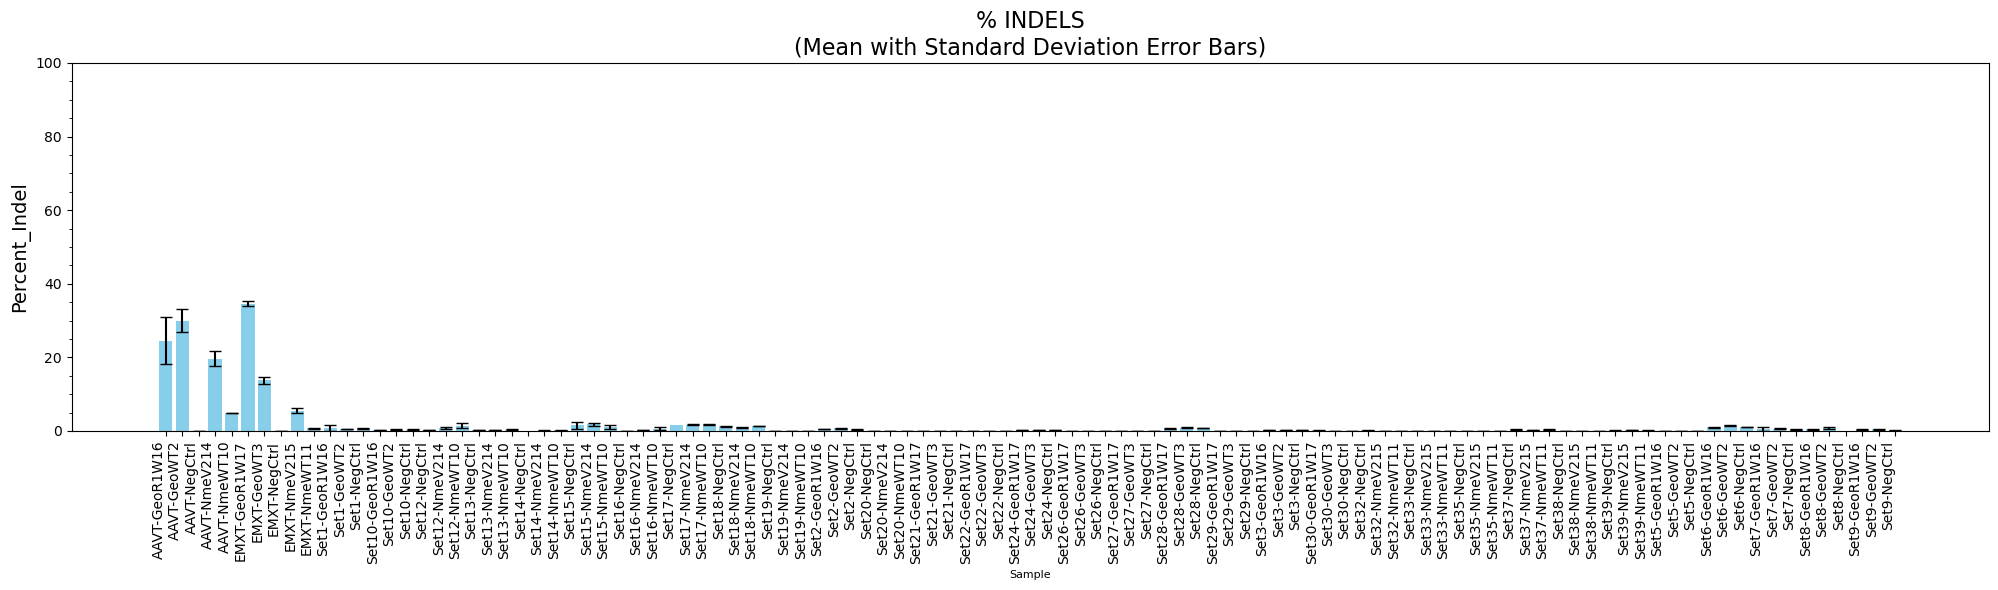

In [5]:
## PLOT AGG STATS FOR INDELS: Mean and Stdev
summary_stats = run_summary.groupby('Feature_Type')['Percent_Indel'].agg(['mean', 'std']).reset_index()

## PLOT
fig, ax = plt.subplots(figsize=(20, 6))  # You can adjust the figure size as needed

# BAR CHART
ax.bar(summary_stats['Feature_Type'], summary_stats['mean'], yerr=summary_stats['std'], capsize=4, color='skyblue')

# FORMAT AXIS LABELS AND TITLES
ax.set_xlabel('Sample', fontsize=8)
ax.set_ylabel('Percent_Indel', fontsize=14)
ax.set_title('% INDELS\n(Mean with Standard Deviation Error Bars)', fontsize=16)

# AXIS TICKS AND ROTATION
plt.xticks(rotation=90, ha='right')
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout() 
plt.ylim(0,100)

plt.savefig(f"Percent_Indels_iGeo_Manuscript_Samples_vAll.png")
#plt.show()
